In [ ]:
%matplotlib

In [ ]:
%matplotlib inline

In [ ]:
pd.set_option('display.max_rows',    100)      # DataFrame 데이터 확인 시 최대 표시 행 수
pd.set_option('display.max_columns', 100)      # DataFrame 데이터 확인 시 최대 표시 열 수

## 라이브러리 import

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import tensorflow as tf
from tensorflow import keras
tf.random.set_seed(777)

## 데이터 불러오기

In [3]:
Fold = 5

# k-fold 학습/검증 데이터
for i in range(Fold):
    
    path1 = './K_FoldData/Training_Fold%d'%(i+1)
    path2 = './K_FoldData/Validation_Fold%d'%(i+1)
    c1 = 'Training_Fold%d   = np.array(pd.read_csv(path1, sep=",", header=None))'%(i+1)
    c2 = 'Validation_Fold%d = np.array(pd.read_csv(path2, sep=",", header=None))'%(i+1)
    exec(c1)
    exec(c2)

# K-fold 학습/검증 레이블
TrainingFold_Label   = np.array(pd.read_csv('./K_FoldData/TrainingFold_Label_forANN'  , sep=",", header=None))
ValidationFold_Label = np.array(pd.read_csv('./K_FoldData/ValidationFold_Label_forANN', sep=",", header=None))
    
    
# 전체 학습용 데이터
Training_All       = np.array(pd.read_csv('./K_FoldData/Training_All', sep = ",", header = None))
Training_All_Label = np.array(pd.read_csv('./K_FoldData/Training_All_Label_forANN', sep = ",", header = None))

print(Training_Fold1.shape)
print(Validation_Fold1.shape)
print(TrainingFold_Label.shape)
print(ValidationFold_Label.shape)
print(Training_All.shape)

(256, 30)
(64, 30)
(256, 2)
(64, 2)
(320, 30)


## ANN(Artificial Neural Network) hyperparameter 설정

In [4]:
learningRate  = 0.0001
noOfNeuron    = 16
iteration     = 2000 #이터레이션 개수 줄임

## Keras 기반 ANN 구조(Architecture) 설계

https://keras.io/api/layers/activations/ : 활성화 함수 참고

In [5]:
def ANN_model(input_data):
    model = keras.Sequential() #레이어가 연속적으로 쌓인 모델이다
    model.add(keras.layers.Dense(units = noOfNeuron, input_shape = (input_data.shape[1],) ))  # Input  Layer
    model.add(keras.layers.Dense(units = noOfNeuron, activation = keras.activations.relu))    # Hidden Layer 1 relu는 수렴속도가 빠르다
    model.add(keras.layers.Dense(units = noOfNeuron, activation = keras.activations.relu))    # Hidden Layer 2
    model.add(keras.layers.Dense(units = 2,          activation = keras.activations.softmax)) # Output Layer 소프트맥스함수 이진분류
    
    model.compile(optimizer= keras.optimizers.Adam(learning_rate = learningRate), #최적화 함수 다양하다 adam
                  loss=keras.losses.categorical_crossentropy, #로스랑 옵티마이저는 캐라스에서 제공해 준거 사용
                  metrics=['accuracy'])
    return model #구조는 이 코드가 끝

In [6]:
# 모델 구조, 파라미터 개수 확인
tempModel = ANN_model(Training_Fold1)
tempModel.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                496       
_________________________________________________________________
dense_1 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_2 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 34        
Total params: 1,074
Trainable params: 1,074
Non-trainable params: 0
_________________________________________________________________


In [ ]:
첫번째 파라미터 496 //16*16+16은 272  // 16*2+2=34

## Keras 기반 NN(Neural Network) 학습 및 평가 방법

In [7]:
tf.random.set_seed(777)

Data      = Training_Fold1
Data_Val  = Validation_Fold1
Label     = TrainingFold_Label
Label_Val = ValidationFold_Label

model = ANN_model(Data) #데이터의 개수를 알려주기위해 들어간 것 학습은 x

hist = model.fit(Data, Label, epochs=iteration, verbose = 0) #학습은 여기서 한다
Loss, Accuracy = model.evaluate(Data_Val,  Label_Val, verbose=0) #검증데이터 넣고 평가하면

Loss, Accuracy

(0.11136260628700256, 0.96875)

## Keras 기반 NN(Neural Network) 학습 및 검증

In [8]:
Label        = TrainingFold_Label
Label_Val    = ValidationFold_Label
Accuracy_sum = 0

print('[Result of K-fold Cross Validation] \n')

for i in range(Fold):
    tf.random.set_seed(777)
    
    s1= 'Data     = Training_Fold%d'  %(i+1)
    s2= 'Data_Val = Validation_Fold%d'%(i+1)
    exec(s1)
    exec(s2)
    
    model = ANN_model(Data)
    # train model
    hist = model.fit(Data, Label, epochs=iteration, verbose = 0)
    Loss, Accuracy = model.evaluate(Data_Val,  Label_Val, verbose=0)
    Accuracy_sum = Accuracy_sum + Accuracy
    print('Fold {}: {:.2f}%'.format((i+1), Accuracy*100))

print('* Average accuracy : {:.2f}%'.format((Accuracy_sum/Fold)*100))

[Result of K-fold Cross Validation] 

Fold 1: 96.88%
Fold 2: 100.00%
Fold 3: 100.00%
Fold 4: 98.44%
Fold 5: 100.00%
* Average accuracy : 99.06%


## 전체 학습 데이터로 NN 학습 및 모델 저장

In [9]:
IterationForPrintAcc = 200
#케라스에서 함수를 실행할때마다 불러오는 함수 에포크를 진행할때마다 풀러올수 있는 함수
class AccuracyPerEpoch(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        keras.callbacks.Callback() #내부에서 입력할 함수 넣어준다
        if epoch%IterationForPrintAcc == 0:
            print("{} Epochs Accuracy : {:.2f}% ".format(epoch, logs["accuracy"]*100))

In [10]:
tf.random.set_seed(777)    
#이터레이션을 에포크라고 함 케라스에서는
Data  = Training_All
Label = Training_All_Label

model = ANN_model(Data)
hist = model.fit(Data, Label, epochs=iteration, verbose = 0, callbacks = [AccuracyPerEpoch()]) #

print('Final Train Accuracy : {:.2f}%'.format(hist.history['accuracy'][-1]*100))

0 Epochs Accuracy : 50.00% 
200 Epochs Accuracy : 98.44% 
400 Epochs Accuracy : 99.37% 
600 Epochs Accuracy : 99.06% 
800 Epochs Accuracy : 99.37% 
1000 Epochs Accuracy : 99.69% 
1200 Epochs Accuracy : 99.37% 
1400 Epochs Accuracy : 99.69% 
1600 Epochs Accuracy : 99.69% 
1800 Epochs Accuracy : 99.69% 
Final Train Accuracy : 99.69%


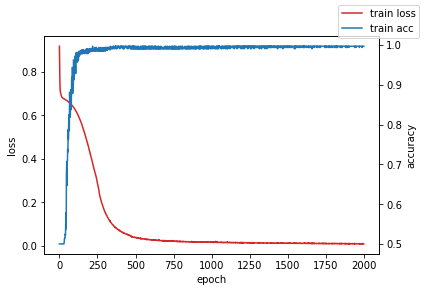

In [11]:
# 학습 과정 확인
fig, loss_ax = plt.subplots()
acc_ax = loss_ax.twinx()

loss_ax.plot(hist.history['loss'], 'y', label='train loss', c = 'tab:red')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
# loss_ax.legend(loc='center right')

acc_ax.plot(hist.history['accuracy'], 'b', label='train acc', c = 'tab:blue')
acc_ax.set_ylabel('accuracy')
fig.legend(loc='upper right')

plt.show()

In [12]:
# 모델 저장
model.save("./MLmodels/ANN_model.h5")

## NN model 불러와서 진단

In [13]:
# 모델 불러오기
LoadedModel = keras.models.load_model("./MLmodels/ANN_model.h5")

In [14]:
Test_Data  = np.array(pd.read_csv('./K_FoldData/Test_Data'        , sep=",", header=None))
Test_Label = np.array(pd.read_csv('./K_FoldData/Test_Label_forANN', sep=",", header=None))

In [15]:
Loss, Accuracy = LoadedModel.evaluate(Test_Data, Test_Label, verbose=0)
print('[Performance of ANN model] \n')
print('Accuracy : {:.2f}%'.format(Accuracy*100))

[Performance of ANN model] 

Accuracy : 100.00%


In [16]:
# 예측값 확인
Predict_y = LoadedModel.predict(Test_Data)
pd.DataFrame(Predict_y) 

,0,1
0,0.999982,1.817379e-05
1,1.000000,2.917330e-08
2,0.999996,4.130767e-06
3,0.999995,4.919055e-06
4,0.996899,3.101273e-03
5,0.961907,3.809313e-02
6,1.000000,5.276949e-07
7,1.000000,5.087211e-07
8,0.999999,6.114255e-07
9,0.999999,1.138367e-06
